In [1]:
from pathlib import Path
from dataclasses import dataclass
import sys

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

%matplotlib inline
%load_ext autoreload
%autoreload 2


@dataclass
class Config:
    REPO_ROOT: Path = Path("../../")
    data_dir: Path = REPO_ROOT / "data"
    seed: int = 42


config = Config()
sys.path.append(str(config.REPO_ROOT))

### 8.1.2 Examples

In [2]:
from python.src.preprocess import (
    preprocess_bike_data,
)

df_bike = pd.read_csv(config.data_dir / "bike-sharing-daily.csv")
df_bike_processed = preprocess_bike_data(df=df_bike)
assert df_bike.shape[0] == df_bike_processed.shape[0]

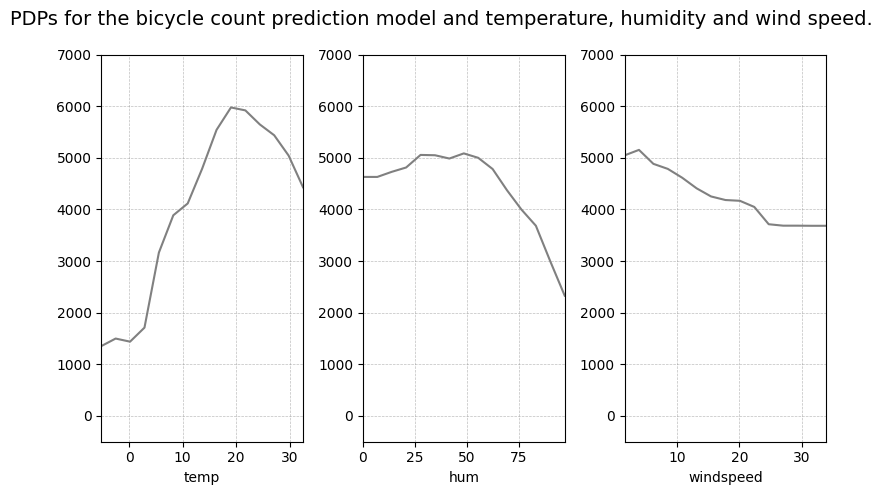

In [3]:
from python.src.utils import PartialDependence

features = ["temp", "hum", "windspeed"]
X = df_bike_processed[features]
y = df_bike_processed["cnt"]
model = RandomForestRegressor(random_state=config.seed)
model.fit(X, y)
pdp = PartialDependence(model=model, X=X, var_names=features, pred_type="regression")

fig, axes = plt.subplots(1, 3, figsize=(8, 5))
for i, (feature, ax) in enumerate(zip(features, axes.ravel())):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    ax.set_ylim(-500, 7000)
    ax.set_xlabel(feature)
    x_min, x_max = df_pd[feature].min(), df_pd[feature].max()
    ax.set_xlim(x_min, x_max)
    ax.plot(df_pd[feature], df_pd["avg_pred"], color="gray")
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
fig.suptitle(
    "PDPs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()

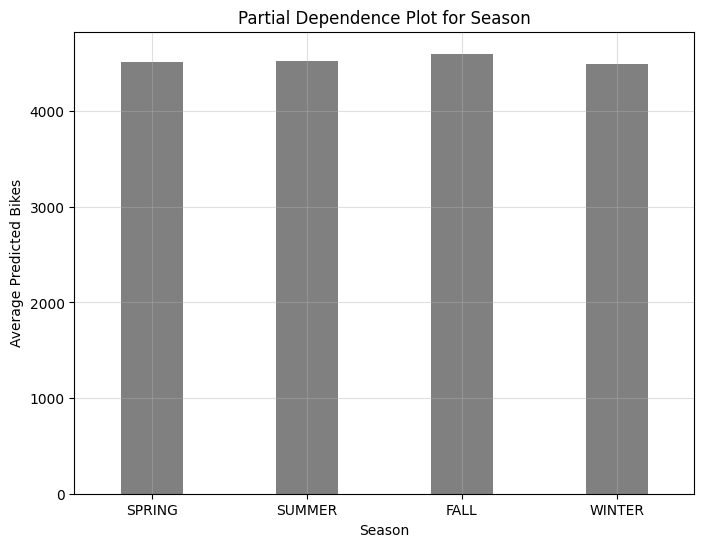

In [4]:
features = ["temp", "hum", "windspeed", "season"]
X = df_bike_processed[features]
X = pd.get_dummies(X, columns=["season"], drop_first=False)
y = df_bike_processed["cnt"]

model = RandomForestRegressor(random_state=config.seed)
model.fit(X, y)
pdp = PartialDependence(model=model, X=X, var_names=X.columns, pred_type="regression")
pd_dict = {}
for i, feature in enumerate(
    ["season_SPRING", "season_SUMMER", "season_FALL", "season_WINTER"]
):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    pd_dict[feature] = float(df_pd["avg_pred"].mean())

x_labels = list([feature.split("_")[1] for feature in pd_dict.keys()])
y_values = list(pd_dict.values())

fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=x_labels, y=y_values, color="gray", ax=ax, width=0.4)
ax.set_xlabel("Season")
ax.set_ylabel("Average Predicted Bikes")
ax.set_title("Partial Dependence Plot for Season")
ax.grid(
    linestyle="-",
    alpha=0.4,
)
plt.show()

In [5]:
from python.src.preprocess import (
    preprocess_rfcc,
)

df_rfcc = pd.read_csv(config.data_dir / "risk_factors_cervical_cancer.csv")
df_rfcc_preprocessed = preprocess_rfcc(df=df_rfcc)
assert df_rfcc.shape[0] == df_rfcc_preprocessed.shape[0]

faetures = ["Age", "Hormonal Contraceptives (years)", "Num of pregnancies"]
X_cervical = df_rfcc_preprocessed[faetures]
y_cervical = df_rfcc_preprocessed["Biopsy"].map({"Healthy": 0, "Cancer": 1})
model_cervical = RandomForestClassifier(random_state=config.seed, max_depth=2)
model_cervical.fit(X_cervical, y_cervical)
pdp = PartialDependence(
    model=model_cervical, X=X_cervical, var_names=faetures, pred_type="classification"
)


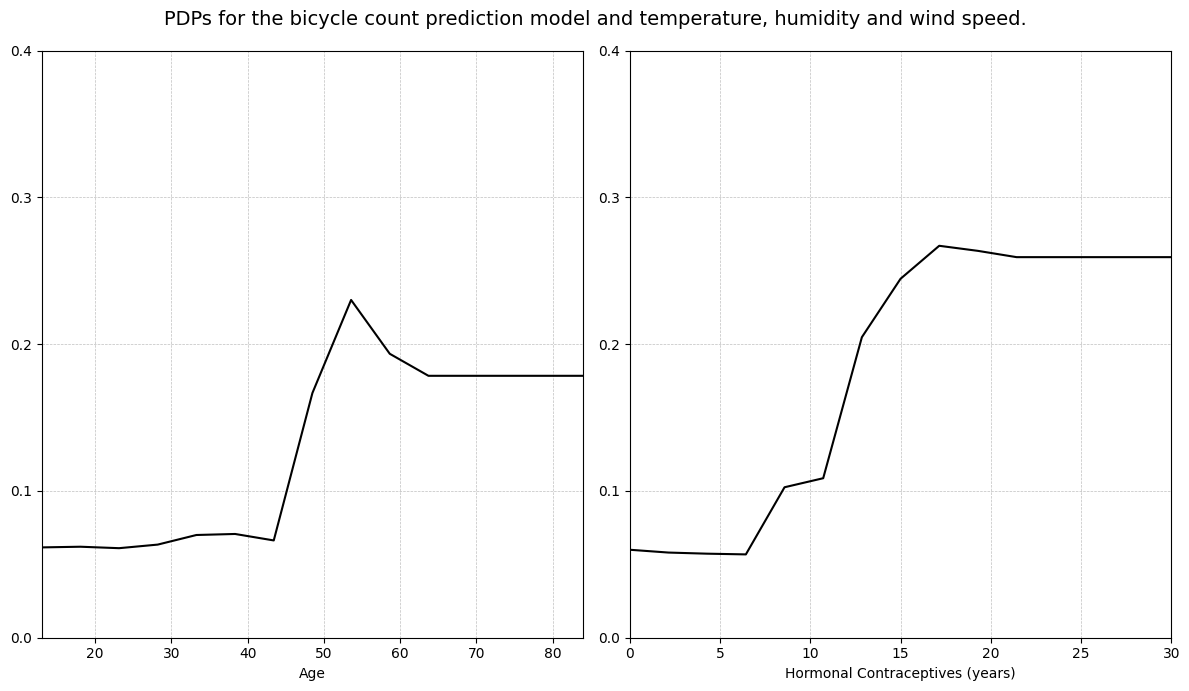

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
for i, (feature, ax) in enumerate(
    zip(["Age", "Hormonal Contraceptives (years)"], axes.ravel())
):
    df_pd = pdp.partial_dependence(feature, n_grid=15)
    x_min, x_max = df_pd[feature].min(), df_pd[feature].max()
    ax.set_xlabel(feature)
    ax.set_xlim(x_min, x_max)
    ax.set_yticks([i * 0.1 for i in range(5)])
    ax.set_ylim(0, 0.4)
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
    ax.plot(df_pd[feature], df_pd["avg_pred"], color="black")

fig.suptitle(
    "PDPs for the bicycle count prediction model and temperature, humidity and wind speed.",
    fontsize=14,
)
plt.tight_layout()
plt.show()


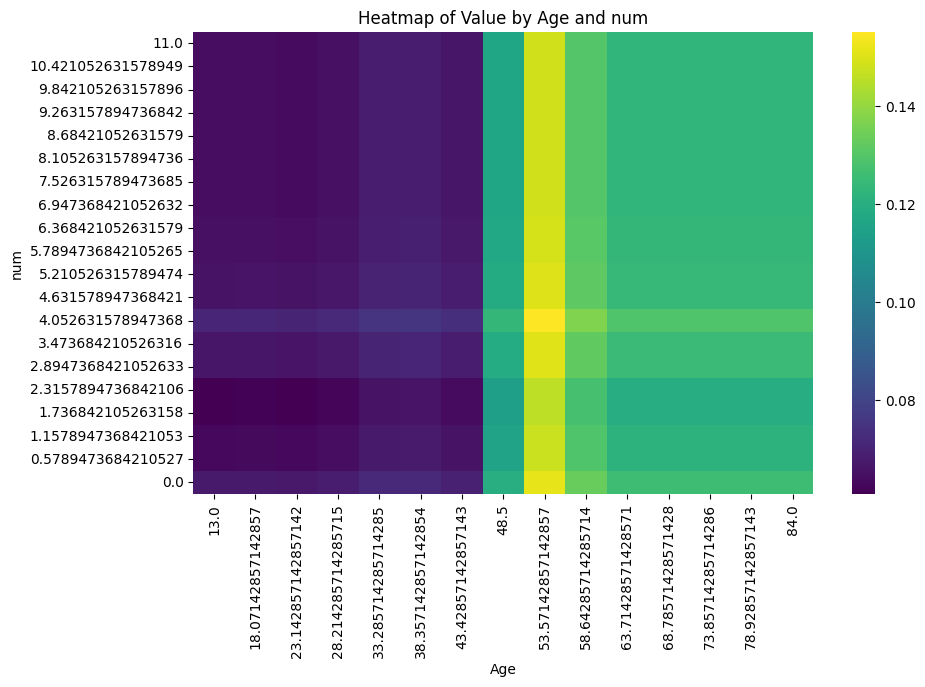

In [7]:
df_pd_age = pdp.partial_dependence("Age", n_grid=15)
df_pd_np = pdp.partial_dependence("Num of pregnancies", n_grid=20)
combined_df = pd.merge(
    df_pd_age,
    df_pd_np.rename(columns={"avg_pred": "avg_pred_2"}),
    how="cross",
)
combined_df["value"] = (combined_df["avg_pred"] + combined_df["avg_pred_2"]) / 2

df_pivot = combined_df.pivot_table(
    index="Num of pregnancies", columns="Age", values="value"
)
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(df_pivot, cmap="viridis", ax=ax, annot=False)
ax.set_xlabel("Age")
ax.set_ylabel("num")
ax.set_title("Heatmap of Value by Age and num")
ax.invert_yaxis()
plt.show()